In [350]:
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from enum import Enum

TRACKING_ID = 0

files = glob.glob('videos/raw/*.pkl')
files = sorted(files)

sns.set_theme(style='darkgrid')
sns.set_palette('rocket')

In [351]:
class RepCounter(object):
    def __init__(self):
        self.is_concentric = False
        self.timestamps = [] # tuples containt time - (start, end)
        self.ys = [] # tuples containing y positions - (start, end)
        self.max_y_diff = None

    def _del_list_by_indexes(self, list, is_to_remove):
        return [el for i, el in enumerate(list) if i not in is_to_remove]

    # TODO: Diff treshold as a variable
    # TODO: Filter out reracking
    def _filter_concentrics(self):
        """
        Check previous concetrics phases and their range of motion
        to filter out exercise setup.
        """
        diff_treshold = self.max_y_diff / 2
        is_to_remove = set()

        for i, (y_start, y_end) in enumerate(self.ys):
            if (y_start - y_end) < diff_treshold:
                is_to_remove.add(i)

        self.ys = self._del_list_by_indexes(self.ys, is_to_remove)
        self.timestamps = self._del_list_by_indexes(self.timestamps, is_to_remove)

    def process_measurements(self, time, x, y, dx, dy):
        # TODO: play with the treshold
        if dy < -0.03 and not self.is_concentric:
            self.start_time = time
            self.start_y = y
            self.is_concentric = True

        if dy > 0 and self.is_concentric:
            # Remember the maximal ROM in Y axis
            y_diff = self.start_y - y
            if self.max_y_diff is None or y_diff > self.max_y_diff:
                self.max_y_diff = y_diff
            
            if y_diff > self.max_y_diff / 2:
                self.timestamps.append((self.start_time, time))
                self.ys.append((self.start_y, y))
                self._filter_concentrics()

            self.is_concentric = False 

    def end_processing(self, time, x, y, dx, dy):
        """
        Check if concentric phase wasn't still in progress when video ended.
        """
        if self.is_concentric:
            self.timestamps.append((self.start_time, time))
            self.ys.append((self.start_y, y))
            self.is_concentric = False 


def find_concentrics(df):
    rep_counter = RepCounter()

    for _, (time, _, _, x, y, dx, dy) in df.iterrows():
        rep_counter.process_measurements(time, x, y, dx, dy)

    rep_counter.end_processing(time, x, y, dx, dy)

    return rep_counter.timestamps

In [352]:
def plot_concentrics(file):
    df = pd.read_pickle(file)
    df = df.query(f'id == {TRACKING_ID}').drop(columns=['id'])
    df.sample(10)

    df_pos = df.drop(columns=['dx', 'dy'])
    df_vel = df.drop(columns=['x_raw', 'x_filtered', 'y_raw', 'y_filtered']).rename(
        columns={'dx': 'x', 'dy': 'y'})

    # Reshape the dataframe into a long format
    df_pos = pd.melt(df_pos, id_vars=['time'],
                        var_name='variable', value_name='value')
    df_pos['filtered'] = df_pos['variable'].str.contains('_filtered')
    df_pos['Position'] = df_pos['variable'].str.extract(r'([xy])')
    df_pos = df_pos.drop(columns=['variable'])
    df_pos = df_pos[['time', 'filtered', 'Position', 'value']]

    filtered = df_pos.query('filtered == True').drop(columns=['filtered'])
    filtered['Position'] = filtered['Position'].map(lambda x: f'{x} filtered')
    raw = df_pos.query('filtered == False').drop(columns=['filtered'])
    raw['Position'] = raw['Position'].map(lambda x: f'{x} raw')

    df_vel = pd.melt(df_vel, id_vars=['time'],
                        var_name='Velocity', value_name='value')

    fig, (pos_ax, vel_ax) = plt.subplots(2, sharex=True, figsize=(8, 8))
    fig.suptitle(file)

    sns.lineplot(
        filtered, x='time', y='value', hue='Position', ax=pos_ax, palette='rocket'
    )
    sns.lineplot(
        raw, x='time', y='value', hue='Position', alpha=0.4, ax=pos_ax, palette='rocket'
    )
    sns.lineplot(
        df_vel, x='time', y='value', hue='Velocity', ax=vel_ax, palette='rocket'
    )

    pos_ax.set(ylabel='[Normalized image coordinates]', xlabel=None, title='Bar position over time')
    pos_ax.legend(ncol=4, loc='upper left')
    vel_ax.set(ylabel=r'[(Normalized image coordinates)$\cdot$s$^{-1}$]', xlabel=None, title='Bar speed over time')

    timestamps = find_concentrics(df)

    # Display repetition phases as background colors
    for start, end in timestamps:
        pos_ax.axvspan(xmin=start, xmax=end, facecolor='C1', alpha=0.15)
        vel_ax.axvspan(xmin=start, xmax=end, facecolor='C1', alpha=0.15)

    plt.xlabel('Time [s]')
    plt.tight_layout()
    plt.show()

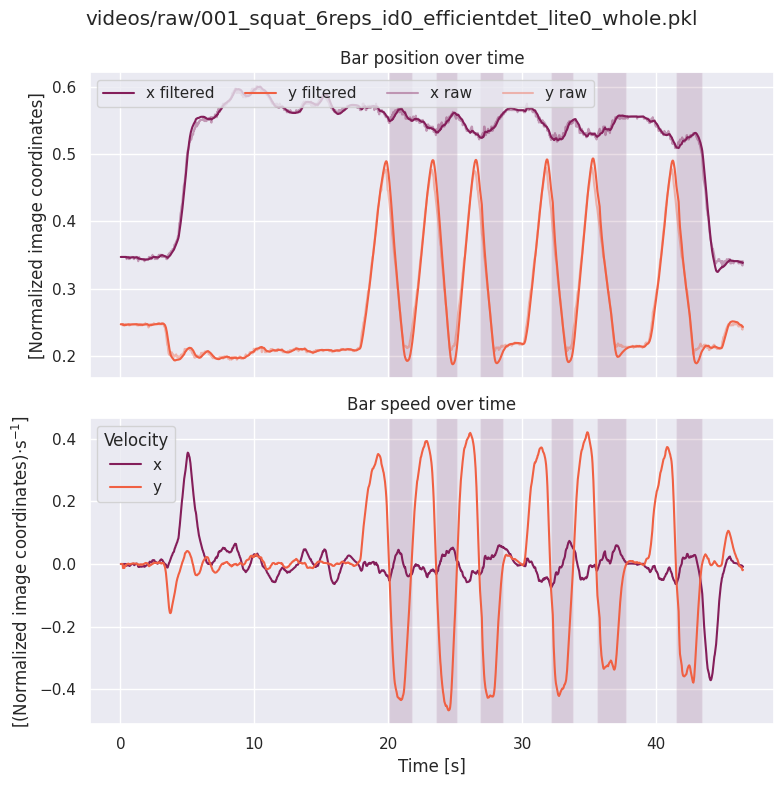

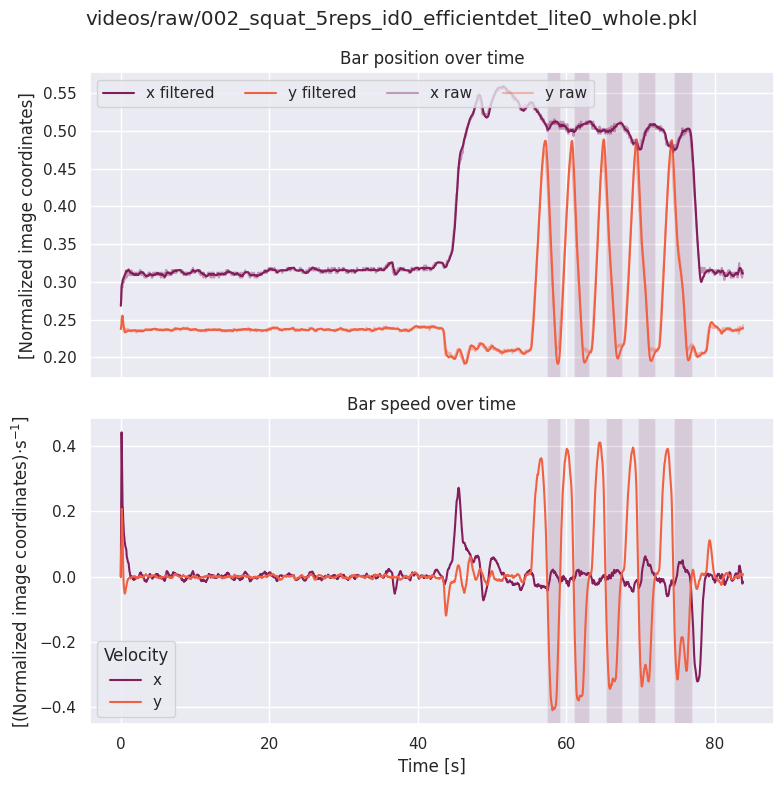

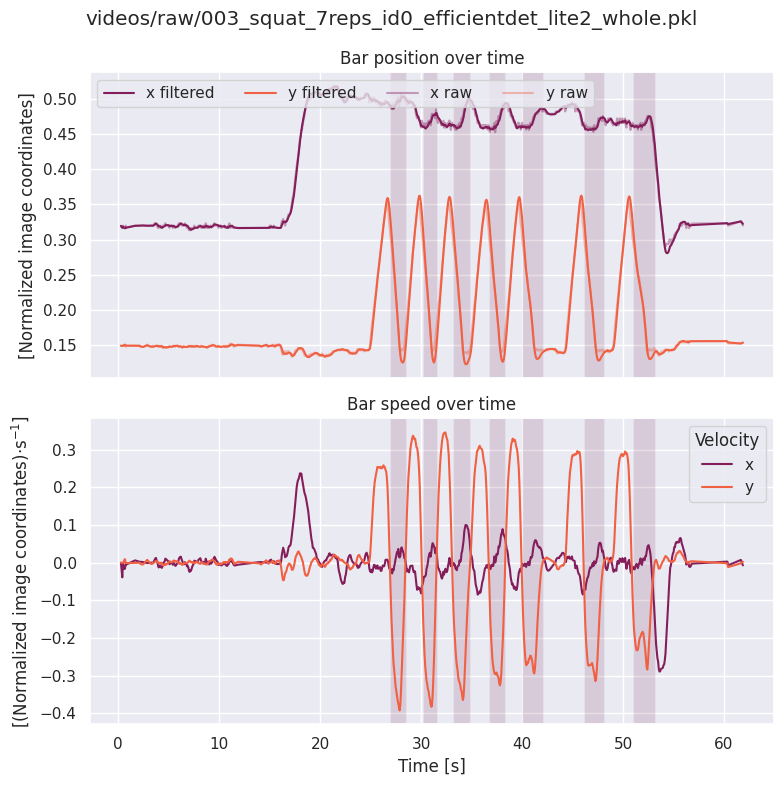

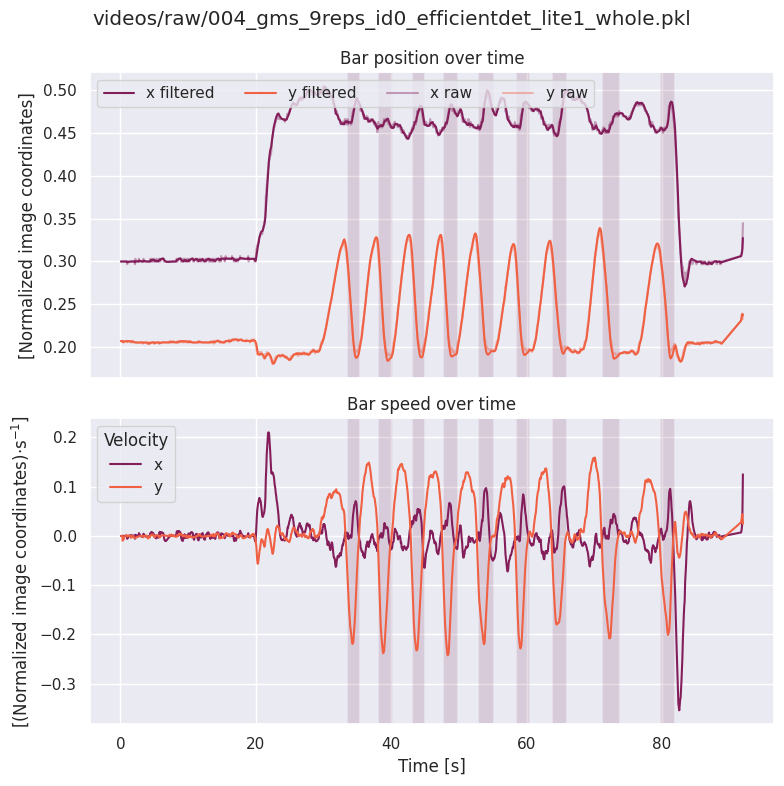

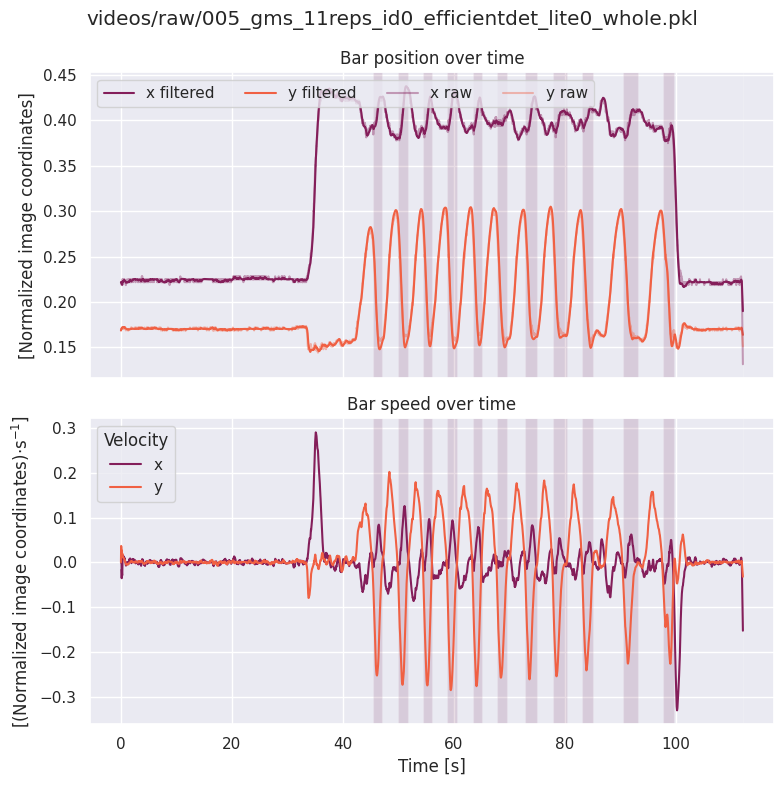

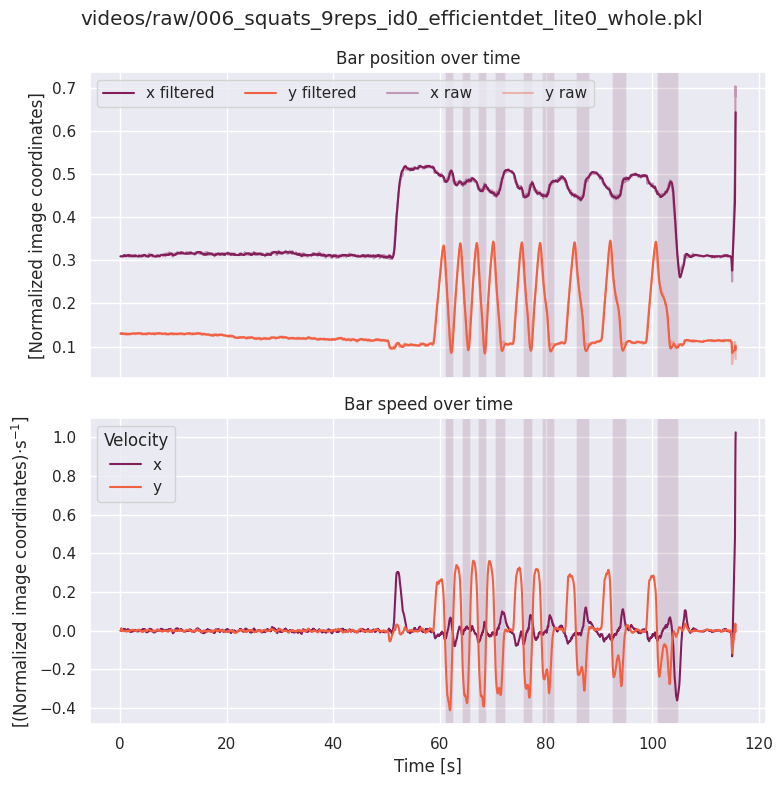

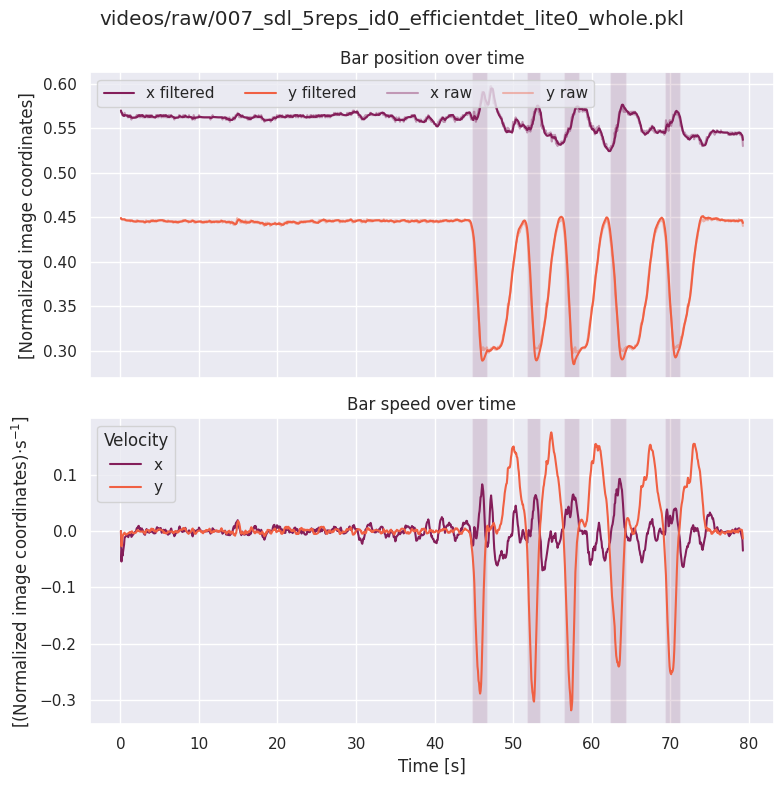

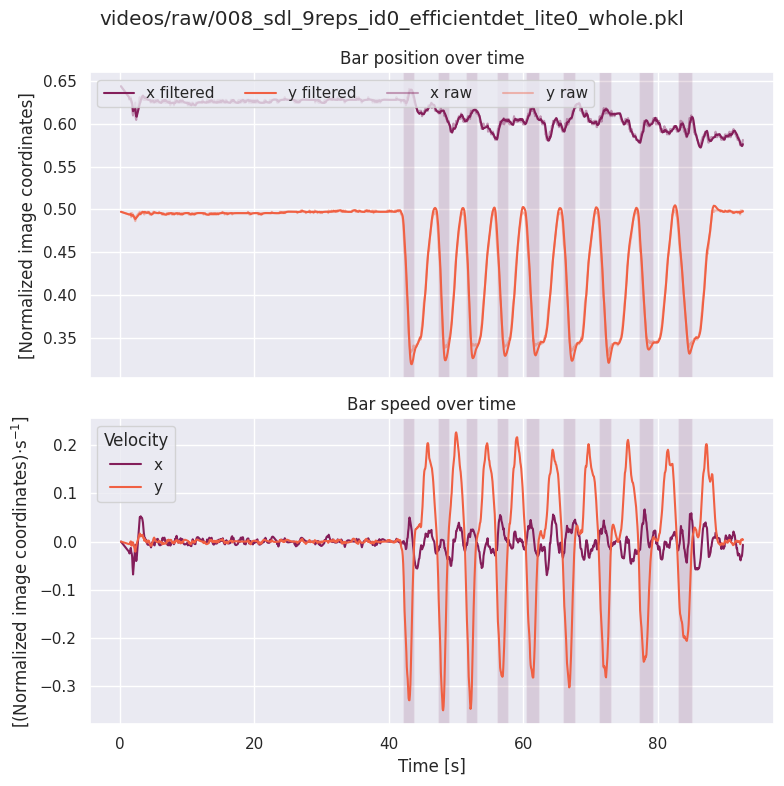

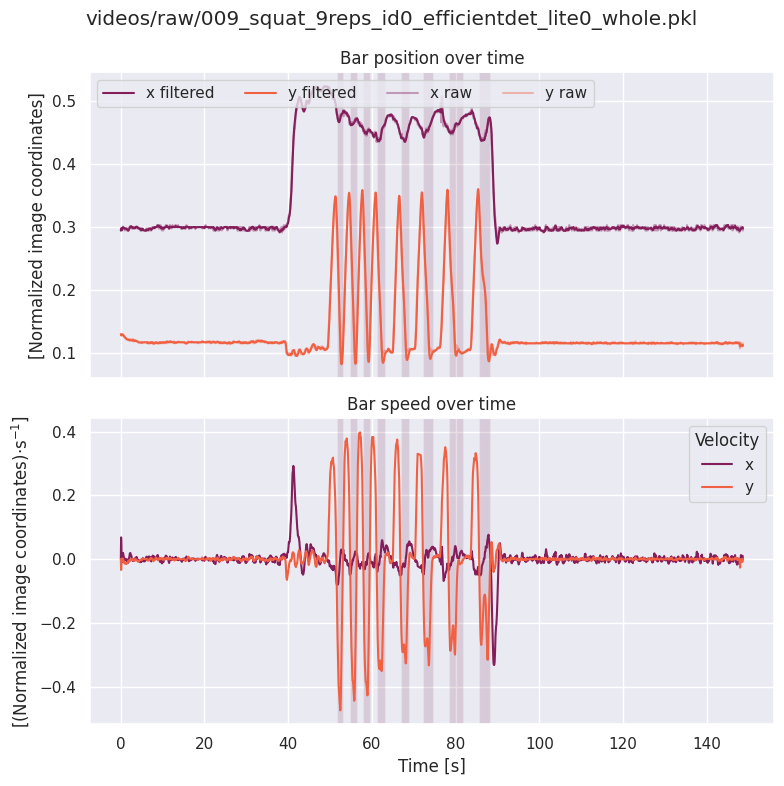

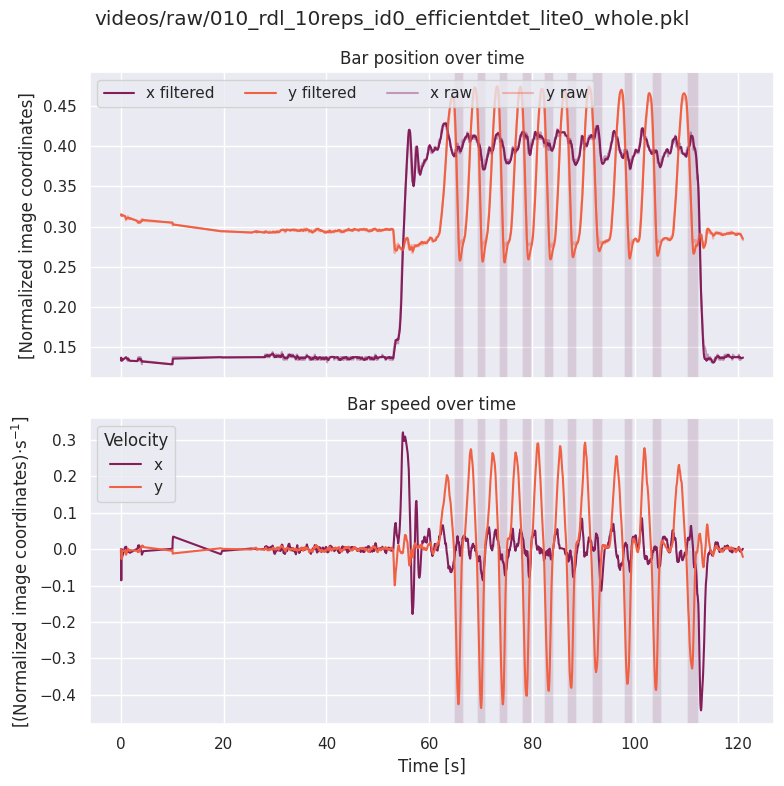

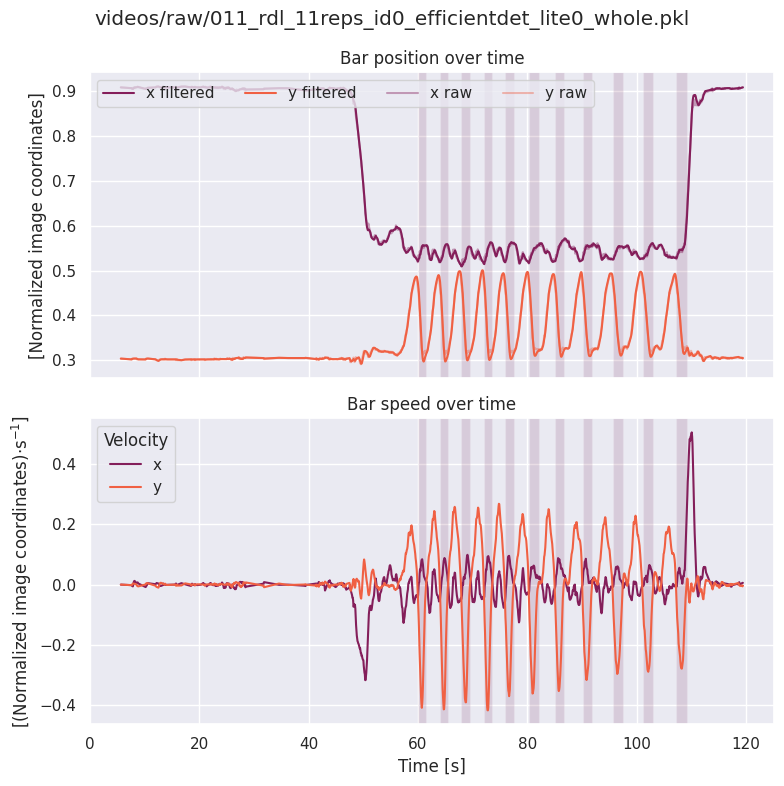

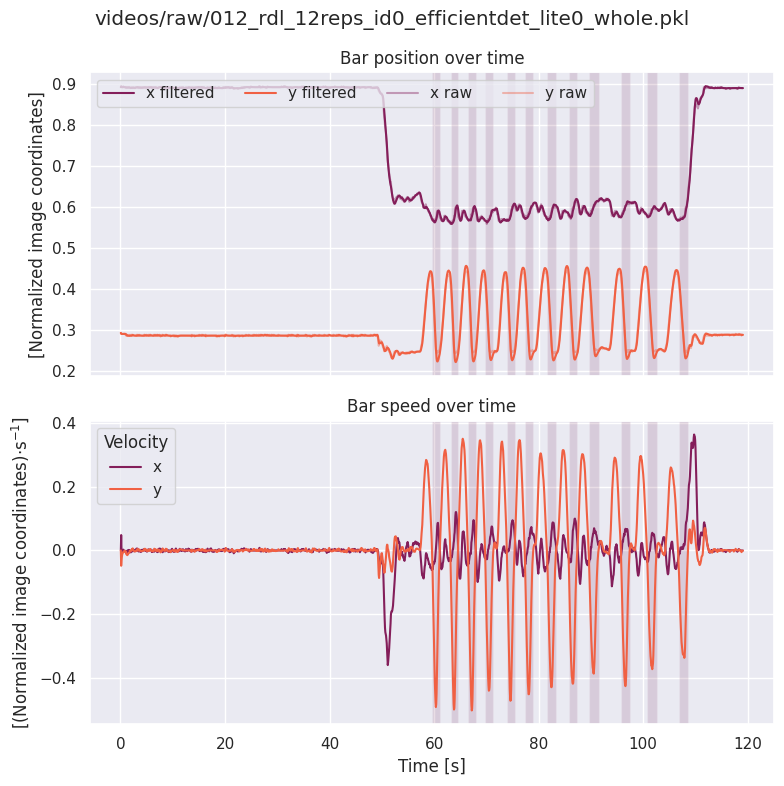

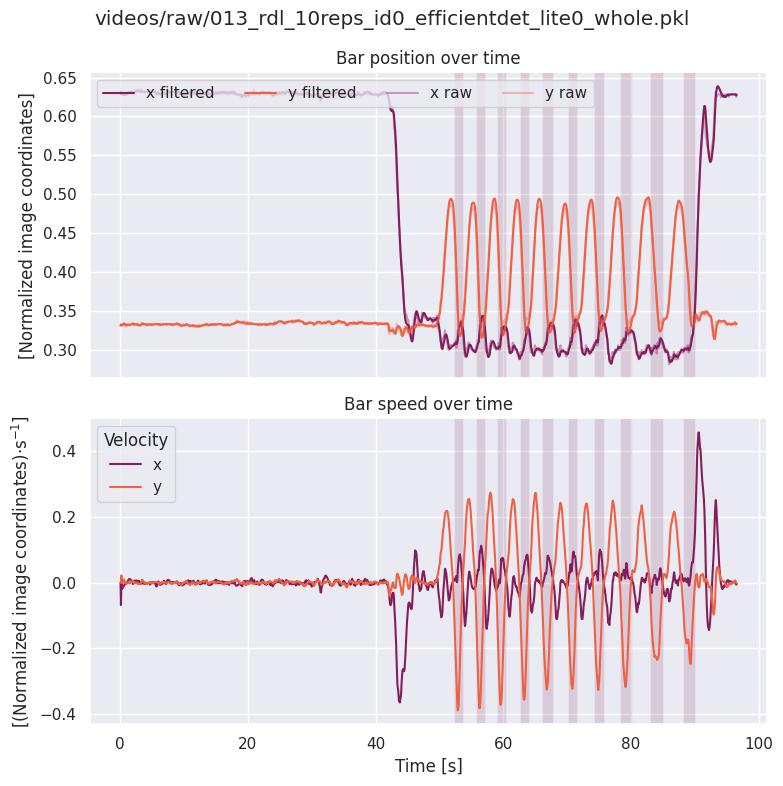

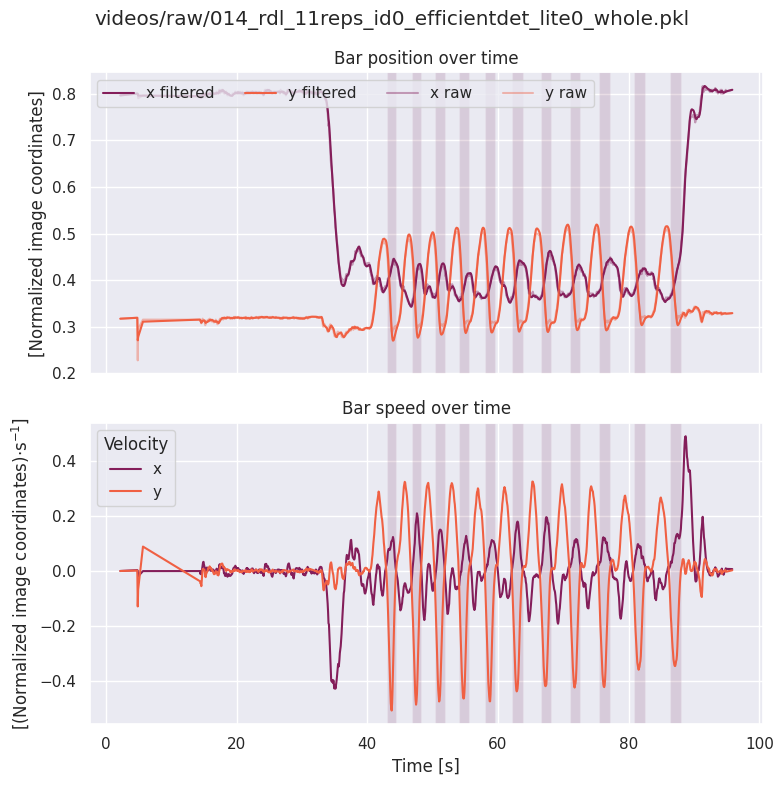

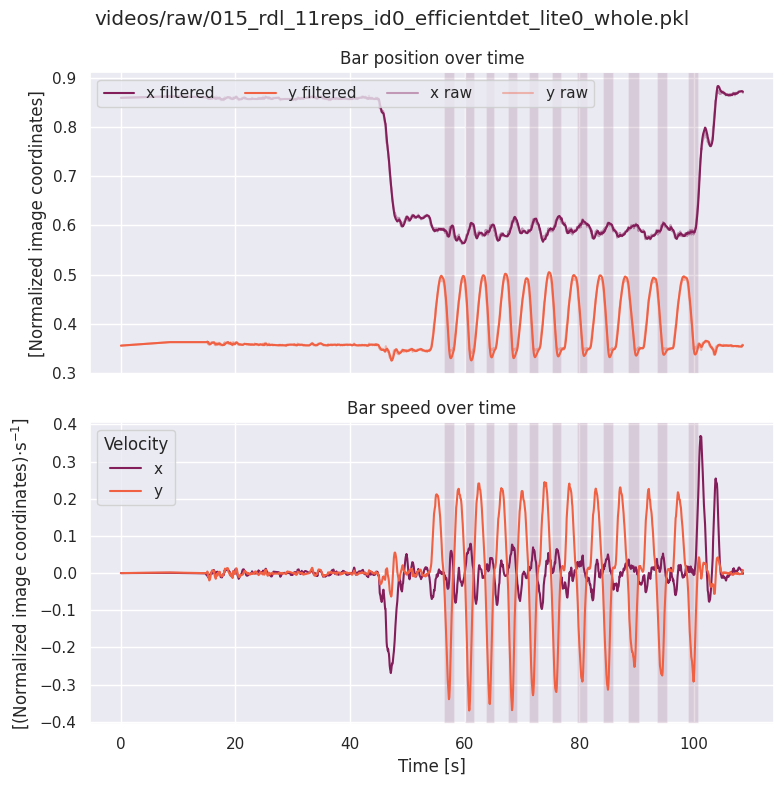

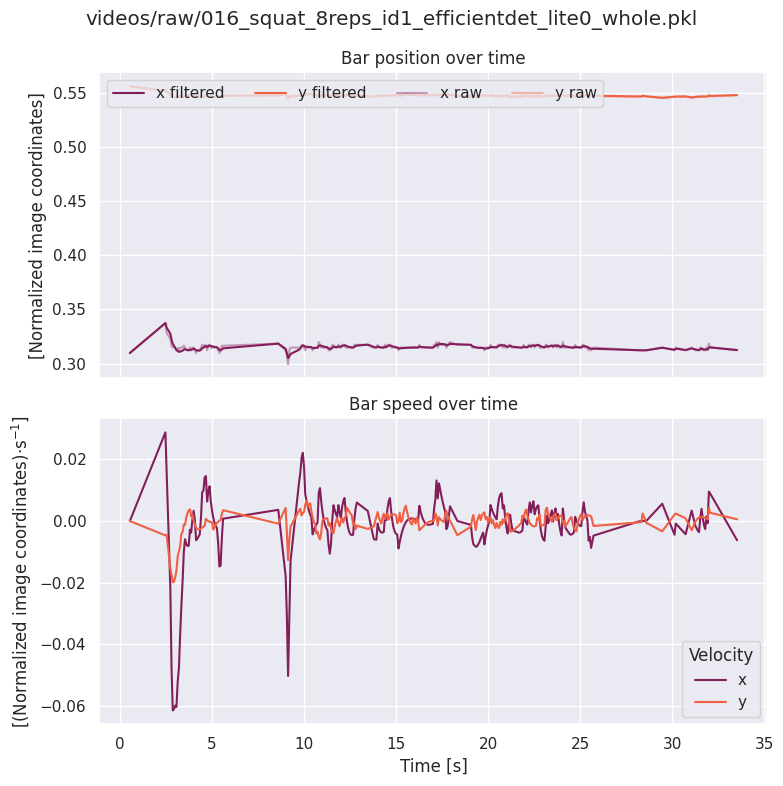

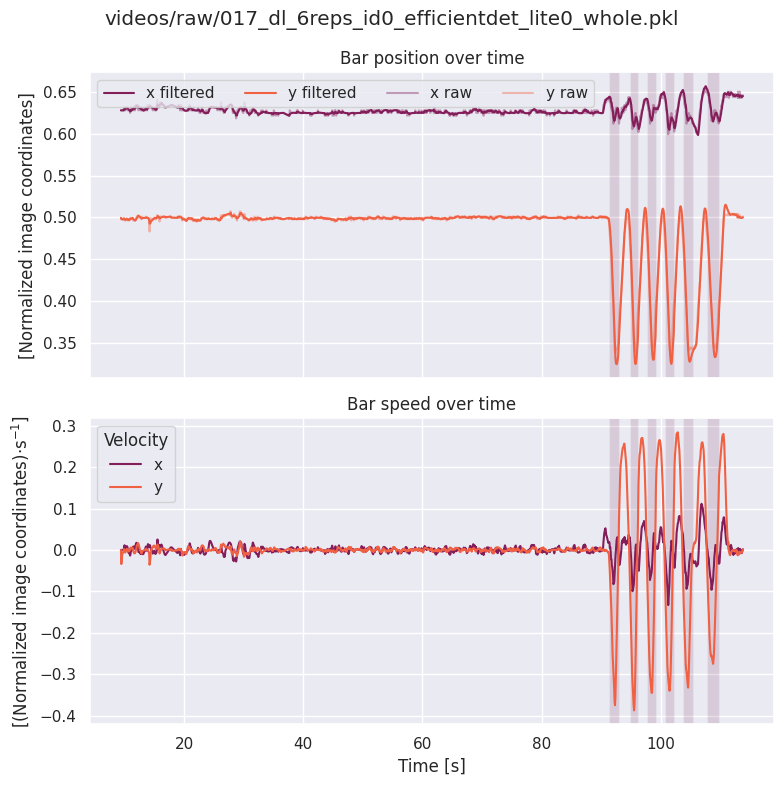

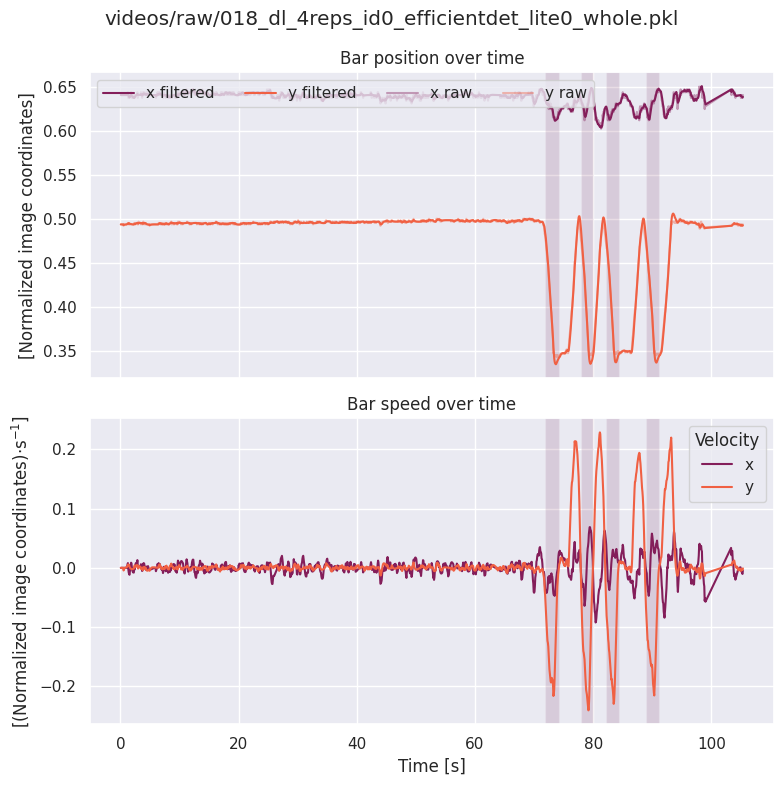

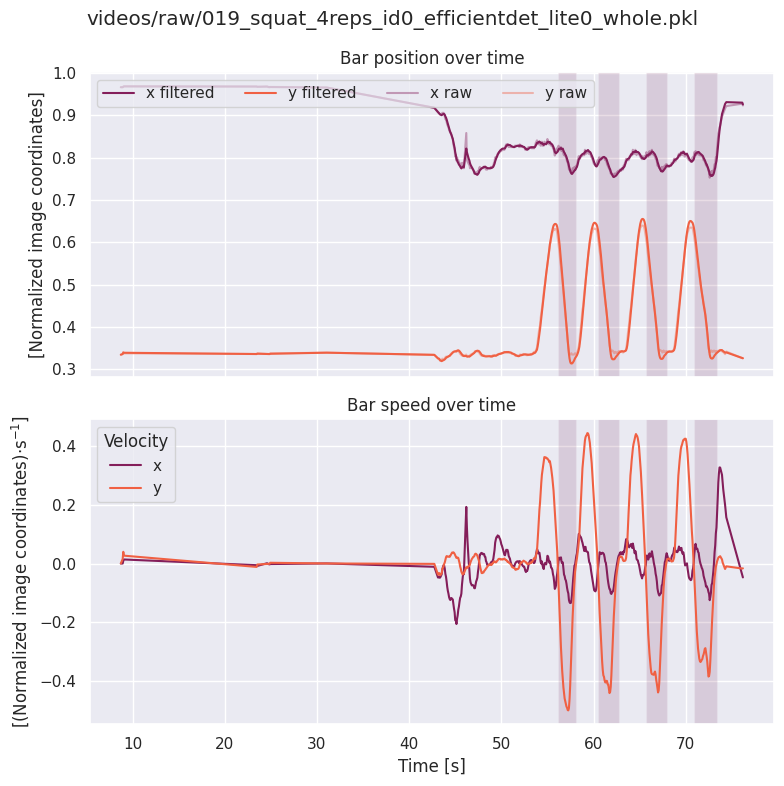

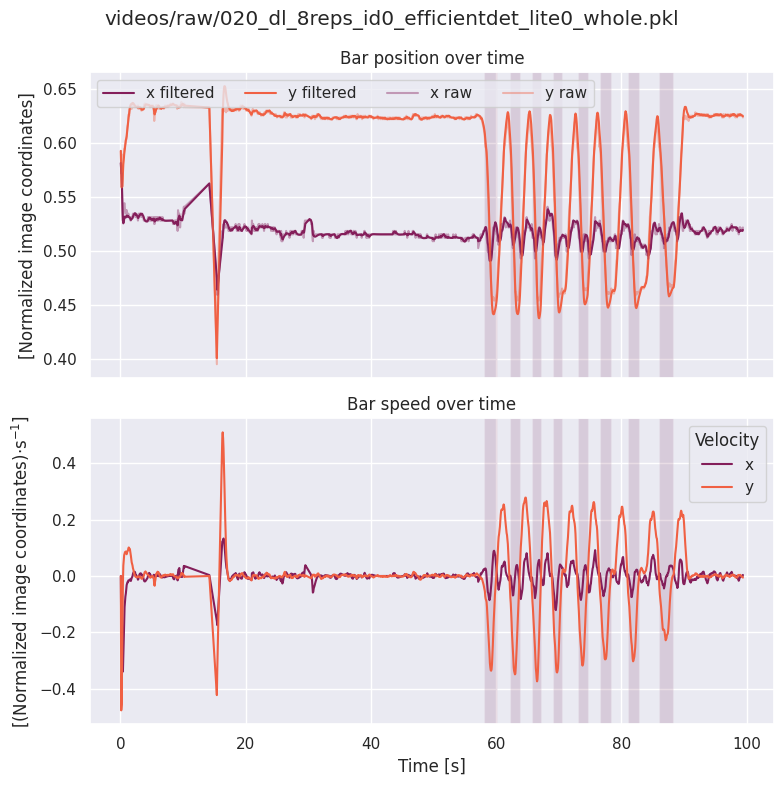

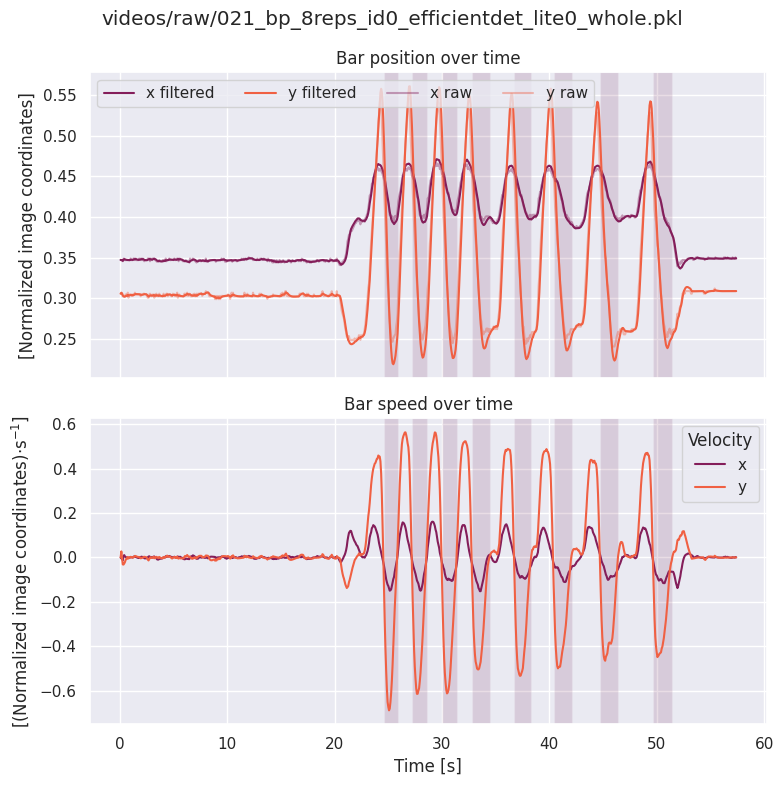

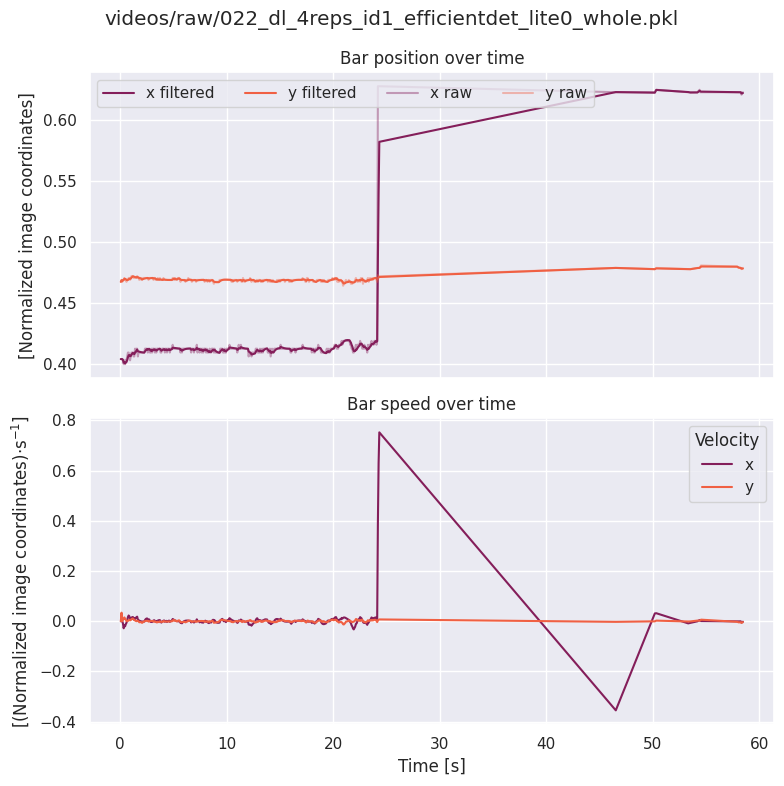

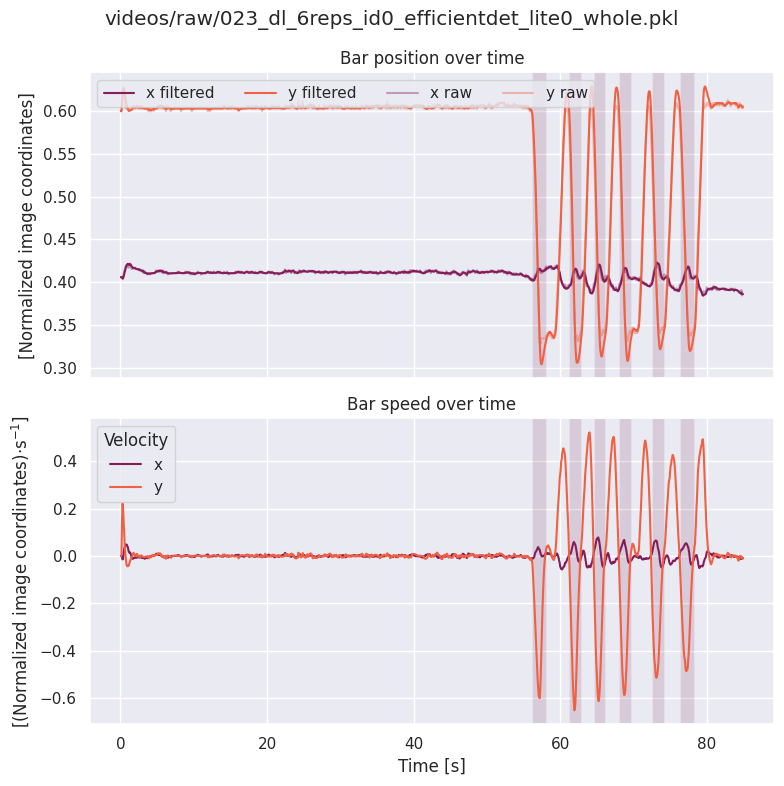

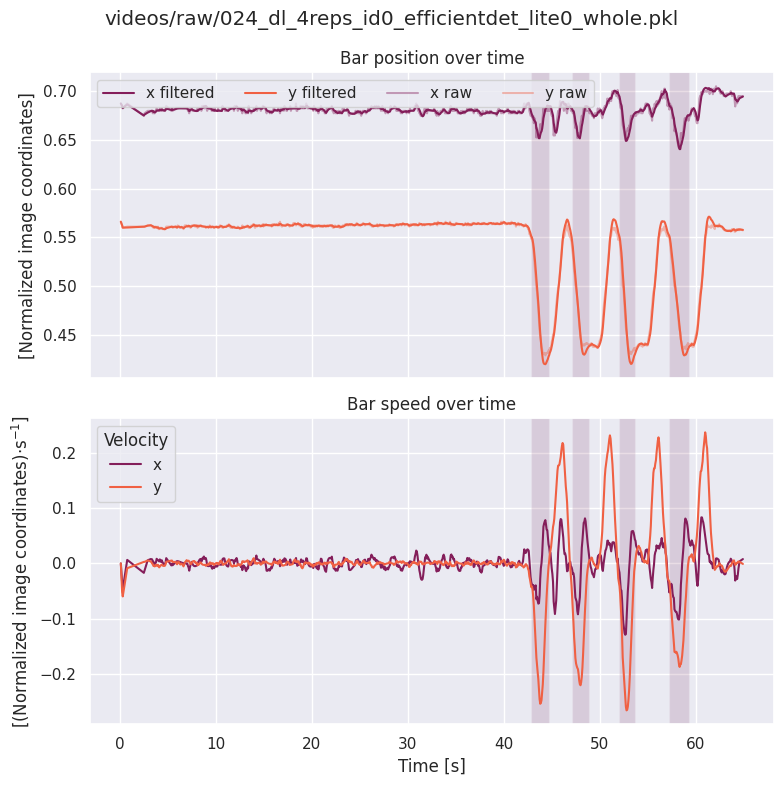

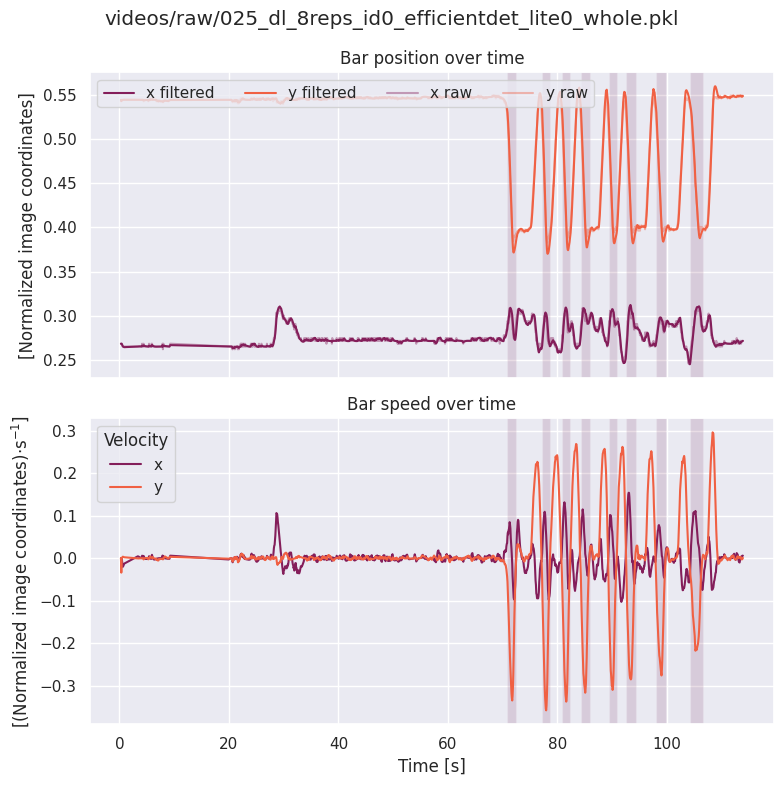

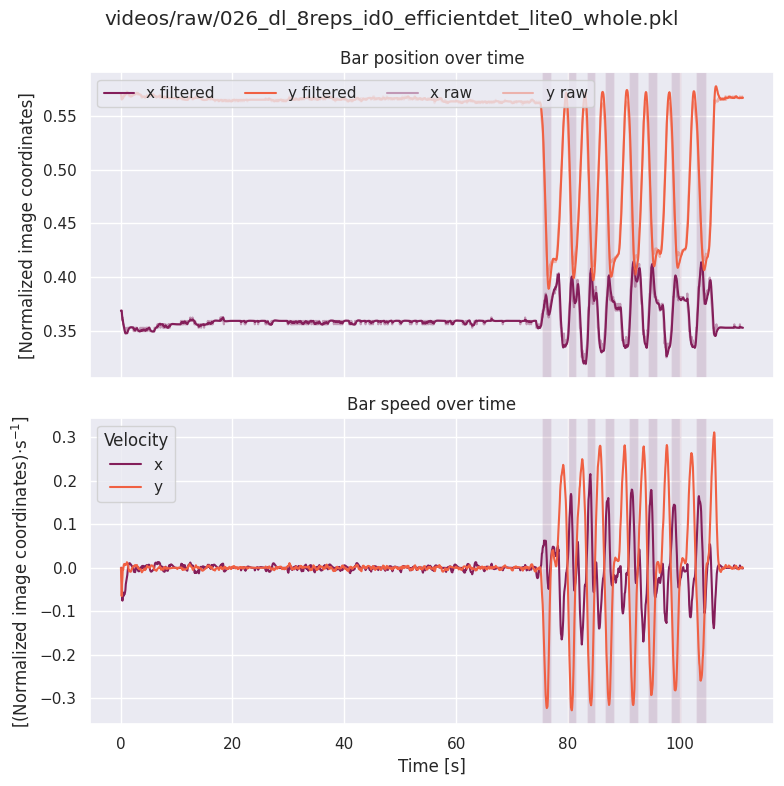

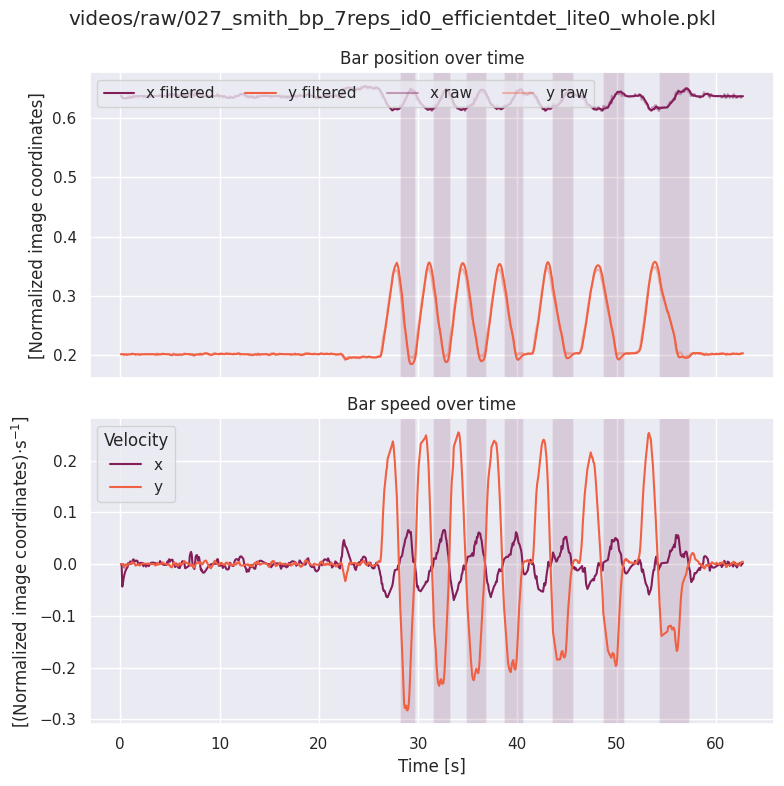

In [353]:
# TODO: Fixme
# for file in files[12:13]:
for file in files:
    plot_concentrics(file)